In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext rpy2.ipython

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/aging_bulk_RNAseq/scripts'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import sklearn
from matplotlib_venn import venn2, venn3
from mpl_toolkits.mplot3d import Axes3D
import gseapy as gp

In [7]:
%R library(DESeq2)

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
  

array(['DESeq2', 'SummarizedExperiment', 'DelayedArray', 'BiocParallel',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], dtype='<U20')

In [8]:
from aging_bulk_misc_scripts_v1_0 import *
from aging_bulk_plot_v1_0 import *
from TenX_aging_mann_whitney_u_v1_0 import *

In [9]:
exp_id = create_ID()


The experiment ID is 202404131446


In [10]:
exp_id = '202212051509'
path_input = '/Users/simjoo/Projects/aging_bulk_RNAseq/data_input/'
path_output = '/Users/simjoo/Projects/aging_bulk_RNAseq/data_output/v1/'
path_figures = '/Users/simjoo/Projects/aging_bulk_RNAseq/figures/'

In [11]:
cmap_tab20 = {str(c) : plt.cm.tab20(c/20) for c in range(20)}
cmap_sex = {'F': '#e78ac3', 'M': '#8da0cb'}
cmap_age = {'A': 'red', 'Y': 'blue'}
cmap_treatment = {'sg31': '#ff7f00', 'sg32': '#e41a1c', 'sgNT2': '#4daf4a'}

# Initialize engines

In [12]:
c = Client()

In [14]:
dview = c[:]

In [15]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/aging_bulk_RNAseq/scripts/")')
dview.execute('from aging_bulk_misc_scripts_v1_0 import *')
dview.execute('from aging_bulk_plot_v1_0 import *')
dview.execute('from TenX_aging_mann_whitney_u_v1_0 import *')

<AsyncResult: execute>

# Compile data

## Import metadata

In [12]:
M = pd.read_csv('%s/Project_13772_I_metadata.csv' % path_input, index_col=1)

In [13]:
Counter(M['Sex'])

Counter({'F': 12, 'M': 18})

In [14]:
Counter(M['Age'])

Counter({'A': 10, 'Y': 20})

In [15]:
Counter(M['Treatment'])

Counter({'sg31': 10, 'sg32': 10, 'sgNT2': 10})

## Load htseq-count output

In [16]:
flist = []
path = '%s/Project_13772_I' % path_input
for fname in os.listdir(path):
    if '.txt' in fname and fname.split('Sample_')[1].split('_IGO')[0] in M.index:
        f = pd.read_csv('%s/%s' % (path,fname), sep = '\t', index_col = 0, header = None)
        f.columns = [fname.split('Sample_')[1].split('_IGO')[0]]
        flist.append(f)

In [17]:
len(flist)

30

In [18]:
X = pd.concat(flist, axis = 1)

## Append metadata

In [19]:
M = M.loc[X.columns]

In [20]:
M = pd.concat([M, X.loc['__no_feature':,:].T],axis=1)

In [21]:
X = X.loc[:'mt-Nd6',:]

In [22]:
M['__aligned_to_genes'] = X.sum(axis=0)

## Checkpoint

In [23]:
save_to_txt(X, path_output, exp_id, 'X_13772_I_raw')
save_to_txt(M, path_output, exp_id, 'M_13772_I')

# (1) Analysis of all samples combined

In [24]:
X = load_from_txt(path_output, exp_id, 'X_13772_I_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_13772_I', 'DataFrame')

## Filter unexpressed genes

In [25]:
X = filter_nonexpressed(X)

31017 genes in dataset
After removing non-expressed genes, 25111 genes remain


## Size factor normalisation in DESeq2

In [26]:
mat_to_DESEq2 = X
coldata_to_DESeq2 = M

In [27]:
%%R -i mat_to_DESEq2 -i coldata_to_DESeq2 -o cnts_DESeq2

dds <- DESeqDataSetFromMatrix(countData = mat_to_DESEq2, colData = coldata_to_DESeq2, design=~1)
dds <- estimateSizeFactors(dds) 
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [28]:
Xs = cnts_DESeq2

## Feature selection

In [29]:
feat = filter_genes(Xs, min_mean=50).index

25111 genes in dataset
After removing genes with mean expression of less than 50 reads, 11535 genes remain


In [30]:
feat = select_features_vst(Xs.loc[feat], n_features = 5000)

In [31]:
Xs = Xs.loc[feat]

## log2 transformation

In [32]:
Xs = np.log2(Xs+1)

## PCA

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=5)
pcs = pd.DataFrame(pca.fit_transform(Xs.T), index = Xs.columns, columns = range(5))

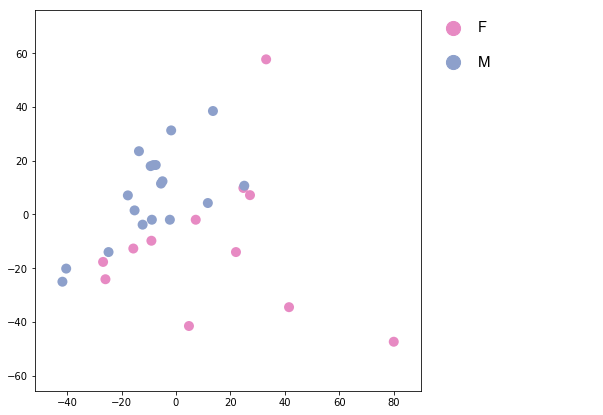

In [35]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M['Sex'][pcs.index],
                    cmap = cmap_sex,
                    s = 100,
                    pad = 10e0)

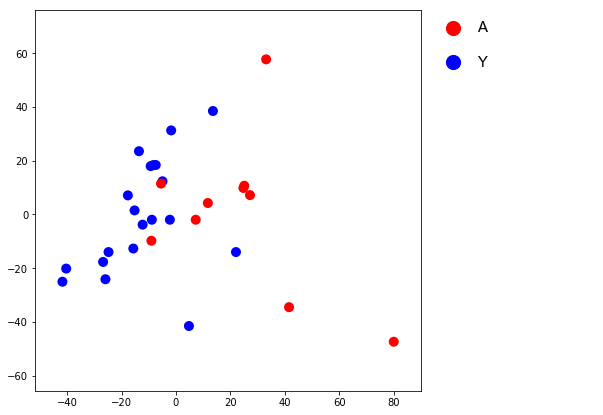

In [38]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M['Age'][pcs.index],
                    cmap = cmap_age,
                    s = 100,
                    pad = 10e0)

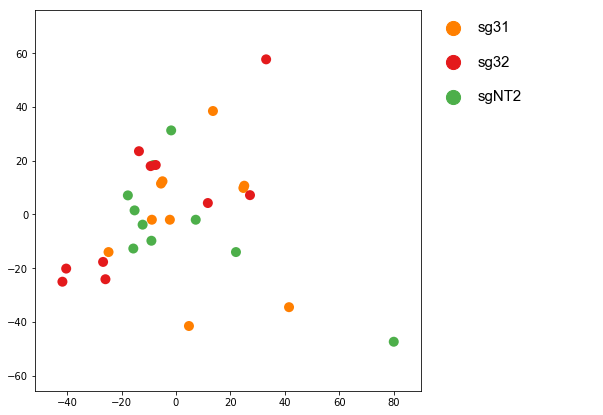

In [39]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M['Treatment'][pcs.index],
                    cmap = cmap_treatment,
                    s = 100,
                    pad = 10e0)

Text(0.5, 0, 'PC3')

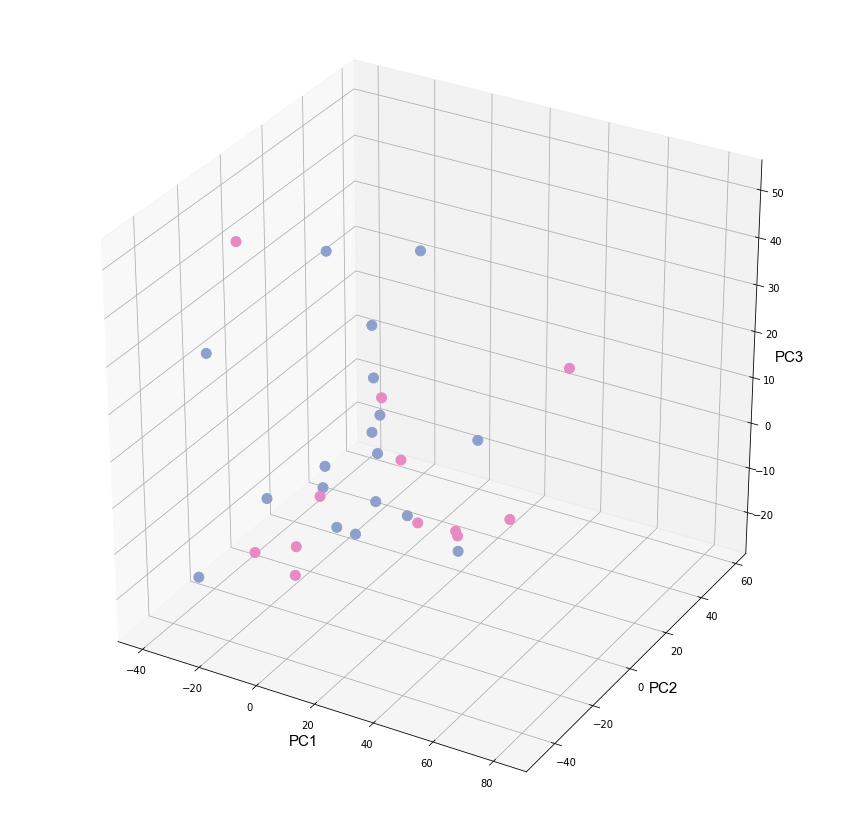

In [40]:
coords = np.array(pcs)[:,0:3]
groups = M['Sex'][pcs.index]
cmap = cmap_sex


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

Text(0.5, 0, 'PC3')

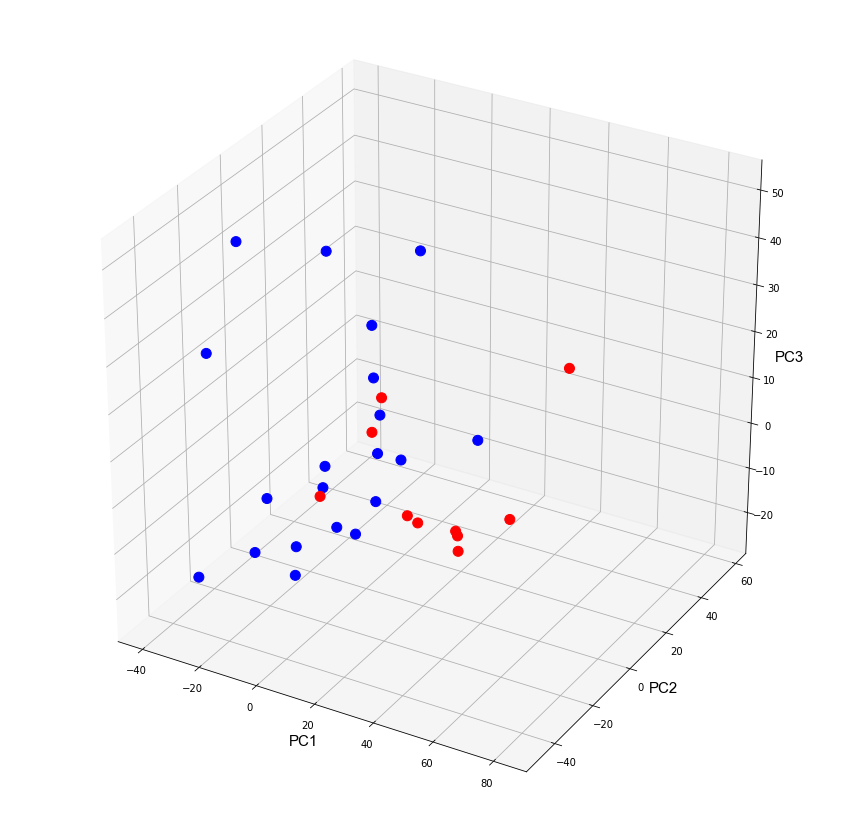

In [41]:
coords = np.array(pcs)[:,0:3]
groups = M['Age'][pcs.index]
cmap = cmap_age


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

Text(0.5, 0, 'PC3')

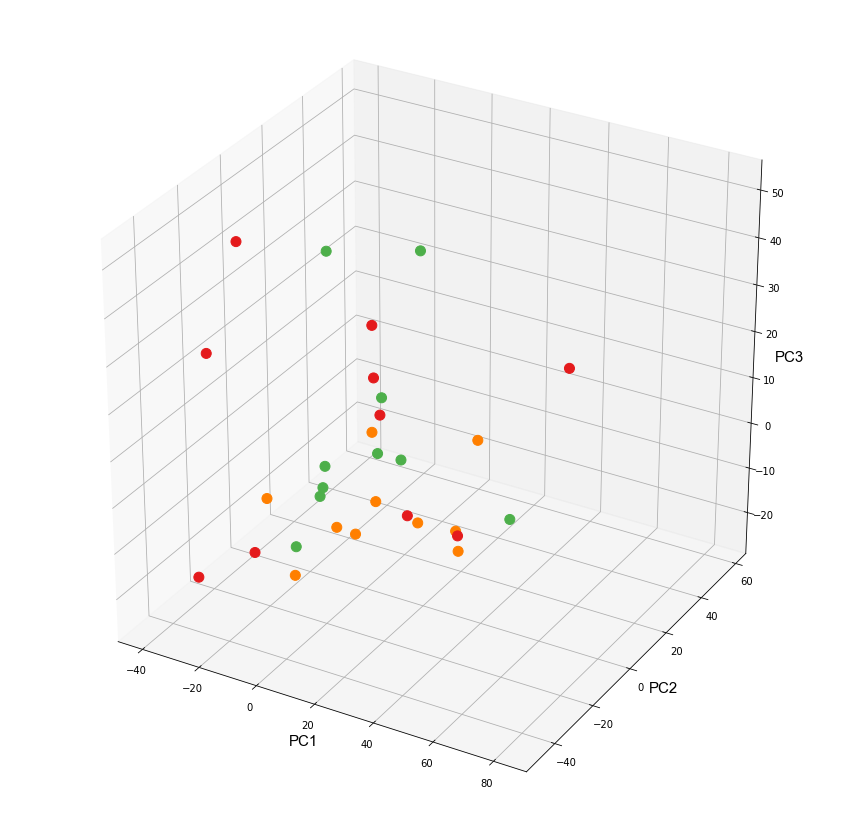

In [42]:
coords = np.array(pcs)[:,0:3]
groups = M['Treatment'][pcs.index]
cmap = cmap_treatment


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

## Ward linkage clustering

In [43]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average

In [44]:
Xdist = pd.DataFrame(squareform(pdist(Xs.T, 'sqeuclidean')), index = Xs.columns, columns = Xs.columns)

In [45]:
Xward = ward(pdist(Xs.T, 'sqeuclidean'))

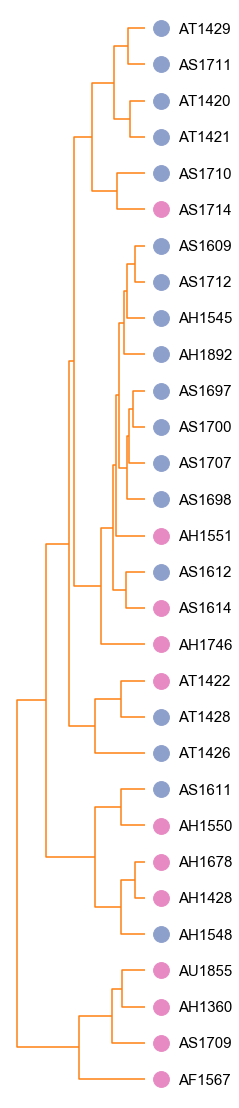

In [46]:
data = Xdist
linkage = Xward
groups = M['Sex'][pcs.index]
cmap = cmap_sex

#create figure and GridSpec

height = 20
width = 3

fig = plt.figure(facecolor = 'w', figsize = (width, height))
heatmapGS = plt.GridSpec(1,2,wspace=0.0,hspace=0.0,width_ratios=[4,1])

#create dendogramm

ax_dend = fig.add_subplot(heatmapGS[0])
den = dendrogram(linkage,color_threshold=np.inf, orientation='left')
leaves = den['leaves']

lines = ax_dend.get_children()[2]
lines.set_color('black')
lines.set_linewidth(3)
    
clean_axis(ax_dend)

#create labels

ax_label = fig.add_subplot(heatmapGS[1])

ax_label.set_ylim(bottom = 0, top = len(leaves))
ax_label.set_xlim(left = 0, right = 1)

for pos, val in enumerate(leaves):

    ax_label.scatter(x = 0.5,
                     y = pos + 0.5 ,
                     c = cmap[groups.loc[data.columns[val]]],
                     s = 250)
    
    ax_label.text(1.0, pos + 0.48, data.columns[val], va = 'center', ha = 'left', family = 'Arial', fontsize = 15)

clean_axis(ax_label)

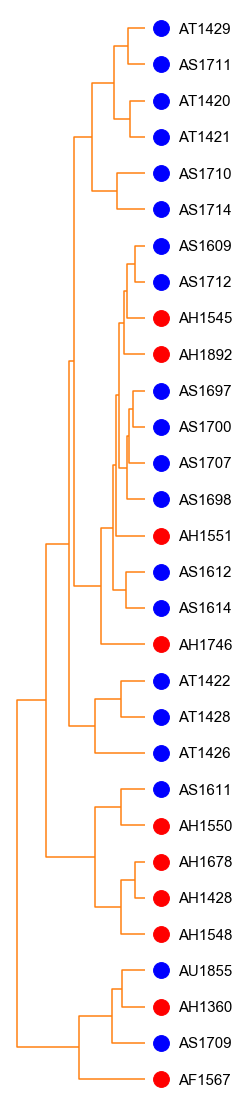

In [47]:
data = Xdist
linkage = Xward
groups = M['Age'][pcs.index]
cmap = cmap_age

#create figure and GridSpec

height = 20
width = 3

fig = plt.figure(facecolor = 'w', figsize = (width, height))
heatmapGS = plt.GridSpec(1,2,wspace=0.0,hspace=0.0,width_ratios=[4,1])

#create dendogramm

ax_dend = fig.add_subplot(heatmapGS[0])
den = dendrogram(linkage,color_threshold=np.inf, orientation='left')
leaves = den['leaves']

lines = ax_dend.get_children()[2]
lines.set_color('black')
lines.set_linewidth(3)
    
clean_axis(ax_dend)

#create labels

ax_label = fig.add_subplot(heatmapGS[1])

ax_label.set_ylim(bottom = 0, top = len(leaves))
ax_label.set_xlim(left = 0, right = 1)

for pos, val in enumerate(leaves):

    ax_label.scatter(x = 0.5,
                     y = pos + 0.5 ,
                     c = cmap[groups.loc[data.columns[val]]],
                     s = 250)
    
    ax_label.text(1.0, pos + 0.48, data.columns[val], va = 'center', ha = 'left', family = 'Arial', fontsize = 15)

clean_axis(ax_label)

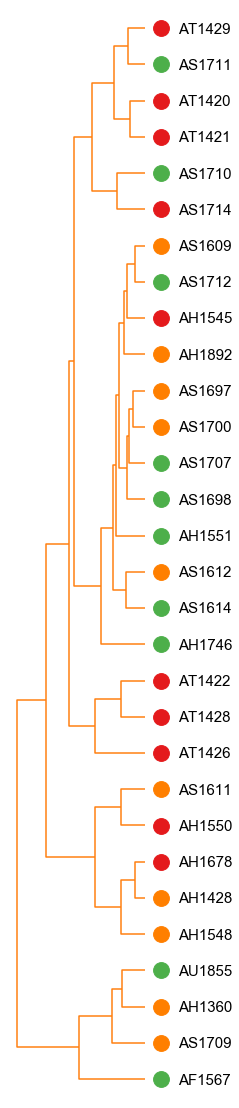

In [48]:
data = Xdist
linkage = Xward
groups = M['Treatment'][pcs.index]
cmap = cmap_treatment

#create figure and GridSpec

height = 20
width = 3

fig = plt.figure(facecolor = 'w', figsize = (width, height))
heatmapGS = plt.GridSpec(1,2,wspace=0.0,hspace=0.0,width_ratios=[4,1])

#create dendogramm

ax_dend = fig.add_subplot(heatmapGS[0])
den = dendrogram(linkage,color_threshold=np.inf, orientation='left')
leaves = den['leaves']

lines = ax_dend.get_children()[2]
lines.set_color('black')
lines.set_linewidth(3)
    
clean_axis(ax_dend)

#create labels

ax_label = fig.add_subplot(heatmapGS[1])

ax_label.set_ylim(bottom = 0, top = len(leaves))
ax_label.set_xlim(left = 0, right = 1)

for pos, val in enumerate(leaves):

    ax_label.scatter(x = 0.5,
                     y = pos + 0.5 ,
                     c = cmap[groups.loc[data.columns[val]]],
                     s = 250)
    
    ax_label.text(1.0, pos + 0.48, data.columns[val], va = 'center', ha = 'left', family = 'Arial', fontsize = 15)

clean_axis(ax_label)

# DEG analysis between aged and young in control samples

In [16]:
X = load_from_txt(path_output, exp_id, 'X_13772_I_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_13772_I', 'DataFrame')

## Filter genes

In [17]:
X = filter_genes(X, min_mean=10)

31017 genes in dataset
After removing genes with mean expression of less than 10 reads, 13787 genes remain


## Select sgNT2 cells

In [19]:
c_sel = M[M['Treatment']=='sgNT2'].index

In [20]:
len(c_sel)

10

In [22]:
Xs = X[c_sel]
Ms = M.loc[c_sel]

In [23]:
Ms

,Expt ID,Sex,Age,Treatment,__no_feature,__ambiguous,__too_low_aQual,__not_aligned,__alignment_not_unique,__aligned_to_genes
AS1707,IGO-13772_I,M,Y,sgNT2,756879,381822,0,5711010,1089461,26027912
AS1712,IGO-13772_I,M,Y,sgNT2,924676,423602,0,5889448,1021707,26802338
AS1711,IGO-13772_I,M,Y,sgNT2,1065238,450009,0,6342733,1053121,25934692
AH1551,IGO-13772_I,F,A,sgNT2,1107129,425132,0,7638318,1031878,26239460
AU1855,IGO-13772_I,F,Y,sgNT2,992371,430800,0,5279502,890219,23804704
AS1614,IGO-13772_I,F,Y,sgNT2,887684,452233,0,6299881,1164183,29627304
AS1710,IGO-13772_I,M,Y,sgNT2,840667,361018,0,5778164,808017,24051845
AF1567,IGO-13772_I,F,A,sgNT2,1550054,380682,0,6468549,903529,26795085
AH1746,IGO-13772_I,F,A,sgNT2,759320,498597,0,5993163,1013620,26474768
AS1698,IGO-13772_I,M,Y,sgNT2,883509,461703,0,6720696,1160469,28470900


## Run DESeq2

In [24]:
samples_to_DESeq2 = Xs.copy()
classes_to_DESeq2 = pd.DataFrame(columns=['Age','Sex'], index=samples_to_DESeq2.columns)
classes_to_DESeq2['Age'] = Ms['Age'].loc[classes_to_DESeq2.index]
classes_to_DESeq2['Sex'] = Ms['Sex'].loc[classes_to_DESeq2.index]

In [25]:
classes_to_DESeq2

,Age,Sex
AS1707,Y,M
AS1712,Y,M
AS1711,Y,M
AH1551,A,F
AU1855,Y,F
AS1614,Y,F
AS1710,Y,M
AF1567,A,F
AH1746,A,F
AS1698,Y,M


In [48]:
%%R -i samples_to_DESeq2 -i classes_to_DESeq2 -o cnts_DESeq2 -o res_DESeq2

dds <- DESeqDataSetFromMatrix(countData = samples_to_DESeq2, colData = classes_to_DESeq2, design = ~Sex+Age)
dds <- DESeq(dds, fitType='local')
res <- results(dds)
res_DESeq2 <- as.data.frame(res)
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [49]:
%%R 

res

log2 fold change (MLE): Age Y vs A 
Wald test p-value: Age Y vs A 
DataFrame with 13787 rows and 6 columns
                      baseMean      log2FoldChange             lfcSE
                     <numeric>           <numeric>         <numeric>
0610009B22Rik 478.154273388655  0.0806391366603291 0.163477595428203
0610009O20Rik 206.220009609935    0.17222893260386 0.271006114599326
0610010F05Rik 624.369525791257  -0.218330537957945 0.389948119247599
0610010K14Rik  38.094575144357   0.221471808275858 0.569463242556323
0610012G03Rik  789.56192212336   0.220213417723385 0.217247286706312
...                        ...                 ...               ...
mt-Nd1        13793.1109529809 -0.0809416231083055 0.243227717519391
mt-Nd2        2874.96246383809  -0.439247564323459 0.252471622192333
mt-Nd4        4748.48151115538  -0.547061485313774 0.327815071664597
mt-Nd5        6035.06697910801  -0.323626324672923 0.321484596420811
mt-Nd6         818.00730258704  -0.578430305994038 0.376318969513

## Checkpoint

In [50]:
save_to_txt(res_DESeq2, path_output, exp_id, 'DESeq2_13772_I_sgNT2_AvsY')

In [51]:
res = load_from_txt(path_output, exp_id, 'DESeq2_13772_I_sgNT2_AvsY', 'DataFrame')

In [52]:
g_sel = ['Nupr1','Lcn2','Fth1','Ftl1','Trf1','Trfc','Cd44','Slc40a1','Hamp',
        'Kdm2a','Kdm2b','Kdm3a','Kdm3b','Jmjd1c','Kdm4a','Kdm4b','Kdm4c','Kdm5a','Kdm5b','Kdm5c','Kdm5d'
        'Kdm6a','Kdm6b','Uty','Kdm7a','Phf8','Phf2','Tet1','Tet2','Tet3']

In [57]:
res.loc[[i for i in g_sel if i in res.index]]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Nupr1,8475.513625,-0.277803,0.306169,-0.907351,0.364221,0.898211
Lcn2,52938.214137,-0.427842,0.500223,-0.855303,0.392383,0.906533
Fth1,45307.315702,-0.438986,0.251127,-1.748062,0.080453,0.646717
Ftl1,54463.018657,-0.167446,0.219349,-0.763378,0.445238,0.932585
Cd44,10423.005987,0.017230,0.285069,0.060443,0.951803,0.996933
Slc40a1,733.795966,-0.046515,0.488106,-0.095297,0.924079,0.995797
Kdm2a,1197.432156,0.256100,0.212523,1.205042,0.228187,0.839078
Kdm2b,392.356173,0.171309,0.308033,0.556139,0.578116,0.948859
Kdm3a,1525.170158,-0.116397,0.229729,-0.506670,0.612386,0.955771
Kdm3b,518.393987,0.250327,0.170899,1.464771,0.142983,0.768399


In [61]:
res.loc[['Scgb1a1','Sftpb','Ager','Cldn4','Onecut2']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Scgb1a1,12623.906752,-3.742535,1.437146,-2.604144,NaN,NaN
Sftpb,132305.728407,0.123962,0.378581,0.327438,0.743336,0.979510
Ager,61461.186417,0.358499,0.346538,1.034515,0.300895,0.877268
Cldn4,3315.166085,0.490012,0.657434,0.745341,0.456065,0.935846
Onecut2,50.112223,-1.854007,1.081018,-1.715057,0.086335,0.660953


In [65]:
res.sort_values(by='padj')[0:25]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Sema3a,394.732098,3.262043,0.414403,7.871669,3.499417e-15,4.686419e-11
Wdfy1,736.050497,-2.361322,0.372364,-6.341441,2.276264e-10,1.524186e-06
Triobp,1790.446462,0.651565,0.105186,6.194391,5.851099e-10,2.611931e-06
Cyp51,1590.039913,-0.925334,0.167020,-5.540260,3.020232e-08,1.011174e-04
Akap5,831.277871,1.741129,0.319252,5.453786,4.930867e-08,1.320683e-04
Gramd1b,386.198590,-1.009046,0.193442,-5.216272,1.825597e-07,4.074732e-04
4930562C15Rik,129.844414,-5.748617,1.120547,-5.130188,2.894528e-07,5.537645e-04
Rps3a1,4191.813798,1.426498,0.283151,5.037940,4.705678e-07,7.877305e-04
Ndc1,472.428083,1.283949,0.259901,4.940153,7.806119e-07,1.161551e-03
Gm9008,14.952300,-4.966311,1.011668,-4.909032,9.152705e-07,1.225730e-03


# DEG analysis of treatment in aged or young

In [12]:
X = load_from_txt(path_output, exp_id, 'X_13772_I_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_13772_I', 'DataFrame')

## Filter genes

In [13]:
X = filter_genes(X, min_mean=10)

31017 genes in dataset
After removing genes with mean expression of less than 10 reads, 13787 genes remain


## Select young cells

In [150]:
c_sel = M[M['Age']=='Y'].index

In [151]:
M_ = M.loc[c_sel]

In [152]:
c_sel = list(M_[M_['Treatment']=='sgNT2'].index) + list(M_[M_['Treatment']=='sg31'].index) + list(M_[M_['Treatment']=='sg32'].index)

In [153]:
len(c_sel)

20

In [154]:
Xs = X[c_sel]
Ms = M.loc[c_sel]

## Run DESeq2

In [155]:
samples_to_DESeq2 = Xs.copy()
classes_to_DESeq2 = pd.DataFrame(columns=['Treatment','Sex'], index=samples_to_DESeq2.columns)
classes_to_DESeq2['Treatment'] = ['sgNupr1' if i in ['sg31','sg32'] else 'sgNT2' for i in Ms['Treatment'].loc[classes_to_DESeq2.index]]
classes_to_DESeq2['Sex'] = Ms['Sex'].loc[classes_to_DESeq2.index]

In [156]:
classes_to_DESeq2

,Treatment,Sex
AS1707,sgNT2,M
AS1712,sgNT2,M
AS1711,sgNT2,M
AU1855,sgNT2,F
AS1614,sgNT2,F
AS1710,sgNT2,M
AS1698,sgNT2,M
AS1700,sgNupr1,M
AS1609,sgNupr1,M
AS1612,sgNupr1,M


In [157]:
%%R -i samples_to_DESeq2 -i classes_to_DESeq2 -o cnts_DESeq2 -o res_DESeq2

dds <- DESeqDataSetFromMatrix(countData = samples_to_DESeq2, colData = classes_to_DESeq2, design = ~Sex+Treatment)
dds <- DESeq(dds, fitType='local')
res <- results(dds)
res_DESeq2 <- as.data.frame(res)
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [158]:
%%R 

res

log2 fold change (MLE): Treatment sgNupr1 vs sgNT2 
Wald test p-value: Treatment sgNupr1 vs sgNT2 
DataFrame with 13787 rows and 6 columns
                      baseMean      log2FoldChange             lfcSE
                     <numeric>           <numeric>         <numeric>
0610009B22Rik 529.406881686967   0.244978367681704 0.134249231059623
0610009O20Rik 203.719790929405 0.00562289778826024 0.128921562288531
0610010F05Rik 526.557487937703  -0.203257471196748 0.140879334722973
0610010K14Rik 42.2635208881865   0.243848270806707 0.243284035651505
0610012G03Rik 920.229881242201   0.253159879122751  0.14278710040927
...                        ...                 ...               ...
mt-Nd1         14569.666496524   0.173134383060503 0.128996665651777
mt-Nd2        2979.20557405909   0.314109262036163 0.191375711266404
mt-Nd4        4962.72710233584   0.365815897997099 0.181575103145358
mt-Nd5        5405.36901887982 -0.0265239870838308 0.151959785249581
mt-Nd6        856.115137883232   

## Checkpoint

In [159]:
save_to_txt(res_DESeq2, path_output, exp_id, 'DESeq2_13772_I_young')

In [217]:
res = load_from_txt(path_output, exp_id, 'DESeq2_13772_I_young', 'DataFrame')

## Heatmap

In [222]:
for i in genes_up:
    print(i)

Nupr1
Alpk2
Adgrg6
Pfkfb3
Ptges
Zfp664
Pld1
Igkv17-127
Snhg18
Capza1
Glis3
Il10ra
Malt1
Tm9sf4
Fam102a
Pstpip2


In [218]:
genes_up = res[(res['log2FoldChange']<-0.1)&(res['padj']<0.1)]['padj'].sort_values().index

In [219]:
len(genes_up)

16

In [163]:
enr_genes_up = gp.enrichr(gene_list=list(genes_up),
                          gene_sets='KEGG_2019_Mouse',
                          organism='Mouse',
                          cutoff=0.05,
                          no_plot=True)

In [164]:
gp.plot.dotplot(enr_genes_up.res2d, top_term=20)

'Warning: No enrich terms when cutoff = 0.05'

In [220]:
genes_dn = res[(res['log2FoldChange']>0.1)&(res['padj']<0.1)]['padj'].sort_values().index

In [166]:
len(genes_dn)

28

In [167]:
enr_genes_dn = gp.enrichr(gene_list=list(genes_dn),
                          gene_sets='KEGG_2019_Mouse',
                          organism='Mouse',
                          cutoff=0.05,
                          no_plot=True)

In [168]:
gp.plot.dotplot(enr_genes_dn.res2d, top_term=20)

'Warning: No enrich terms when cutoff = 0.05'

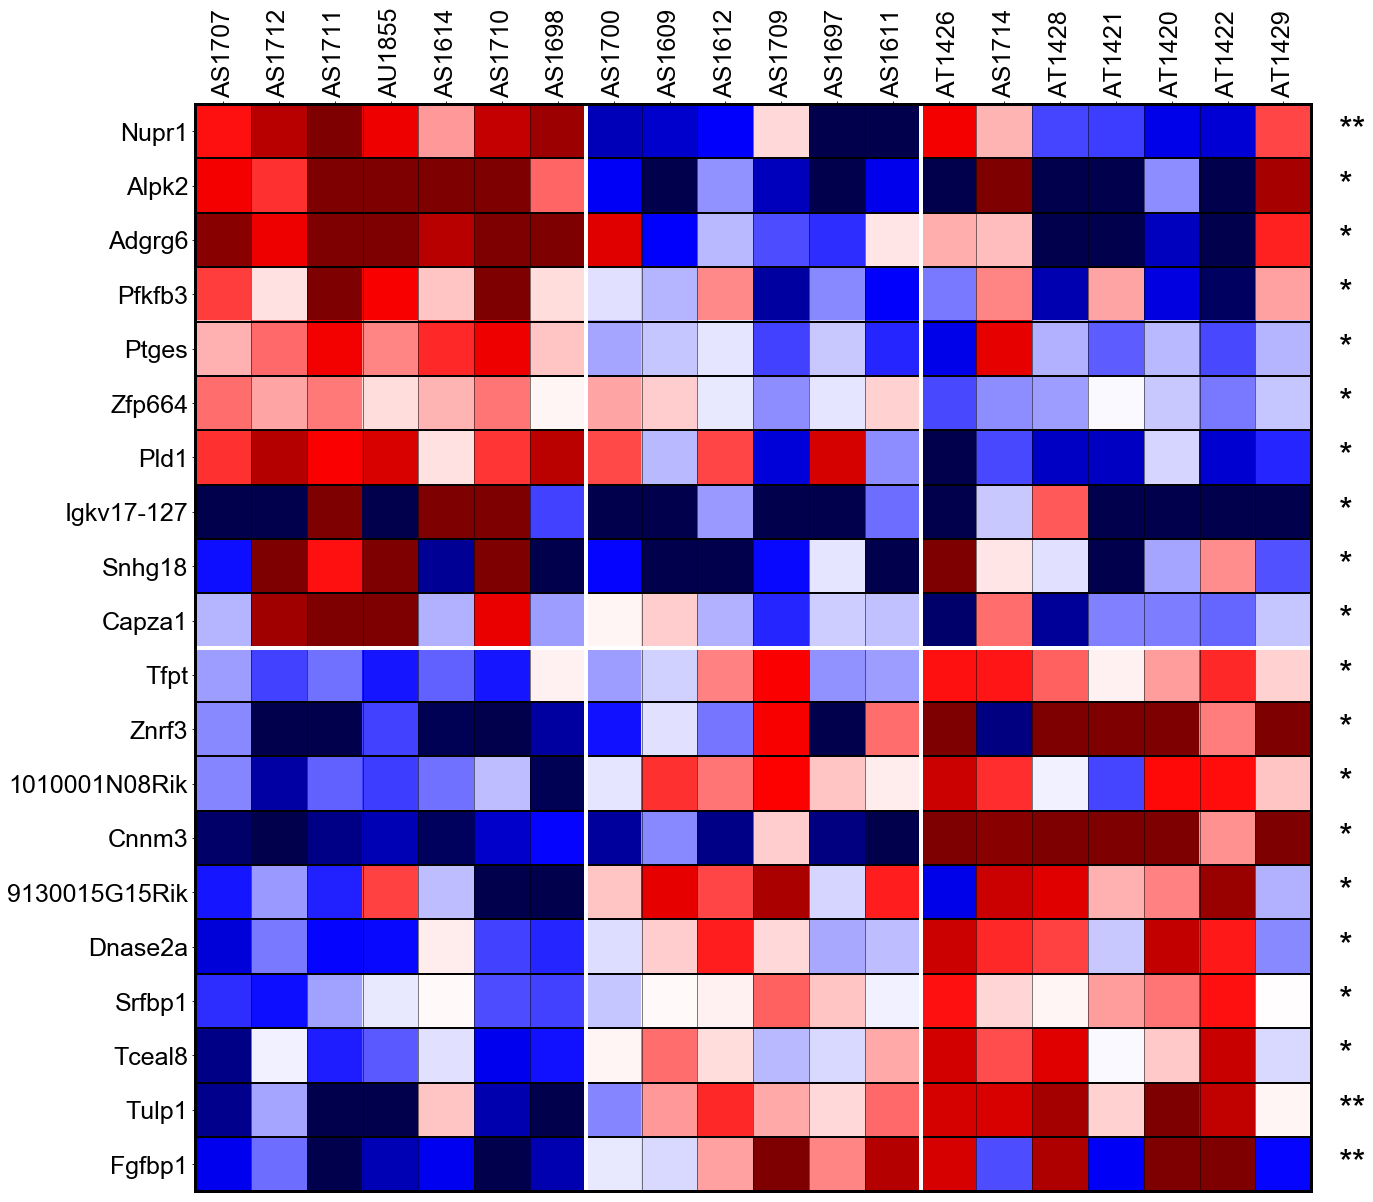

In [169]:
features = list(genes_up[0:10]) + list(genes_dn[0:10][::-1])
groups = c_sel
dat = cnts_DESeq2[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
padj = res['padj']
thr1 = 0.1
thr2 = 0.01
thr3 = 0.001
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

ax.axvline(6+0.5, linewidth = 4, color = 'w')
ax.axvline(12+0.5, linewidth = 4, color = 'w')
ax.axhline(9+0.5, linewidth = 4, color = 'w')

for i, f in enumerate(features):
    if f in padj.index:
        if padj[f] < thr3: ax.text(len(groups), i, '***', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr2: ax.text(len(groups), i, '**', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr1: ax.text(len(groups), i, '*', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')

## Select aged cells

In [170]:
c_sel = M[M['Age']=='A'].index

In [171]:
M_ = M.loc[c_sel]

In [172]:
c_sel = list(M_[M_['Treatment']=='sgNT2'].index) + list(M_[M_['Treatment']=='sg31'].index) + list(M_[M_['Treatment']=='sg32'].index)

In [173]:
len(c_sel)

10

In [174]:
Xs = X[c_sel]
Ms = M.loc[c_sel]

In [176]:
Counter(Ms['Treatment'])

Counter({'sgNT2': 3, 'sg31': 4, 'sg32': 3})

### Run DESeq2

In [203]:
samples_to_DESeq2 = Xs.copy()
classes_to_DESeq2 = pd.DataFrame(columns=['Treatment','Sex'], index=samples_to_DESeq2.columns)
classes_to_DESeq2['Treatment'] = ['sgNupr1' if i in ['sg31','sg32'] else 'sgNT2' for i in Ms['Treatment'].loc[classes_to_DESeq2.index]]
classes_to_DESeq2['Sex'] = Ms['Sex'].loc[classes_to_DESeq2.index]

In [204]:
classes_to_DESeq2

,Treatment,Sex
AH1551,sgNT2,F
AF1567,sgNT2,F
AH1746,sgNT2,F
AH1428,sgNupr1,F
AH1360,sgNupr1,F
AH1548,sgNupr1,M
AH1892,sgNupr1,M
AH1678,sgNupr1,F
AH1545,sgNupr1,M
AH1550,sgNupr1,F


In [205]:
%%R -i samples_to_DESeq2 -i classes_to_DESeq2 -o cnts_DESeq2 -o res_DESeq2

dds <- DESeqDataSetFromMatrix(countData = samples_to_DESeq2, colData = classes_to_DESeq2, design = ~Sex+Treatment)
dds <- DESeq(dds, fitType='local')
res <- results(dds)
res_DESeq2 <- as.data.frame(res)
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [206]:
%%R 

res

log2 fold change (MLE): Treatment sgNupr1 vs sgNT2 
Wald test p-value: Treatment sgNupr1 vs sgNT2 
DataFrame with 13787 rows and 6 columns
                      baseMean      log2FoldChange             lfcSE
                     <numeric>           <numeric>         <numeric>
0610009B22Rik 432.894375975928  -0.379494767815398 0.168753248655807
0610009O20Rik 190.689773511863   -0.16458089111779 0.257169508195216
0610010F05Rik 646.373496279648  -0.339807117279569 0.297095200820473
0610010K14Rik 35.8091814629025  -0.260398457874303 0.388989130240562
0610012G03Rik 711.898831134856 -0.0416296639600852 0.208319174919374
...                        ...                 ...               ...
mt-Nd1        12143.5732206439  -0.283091744344739 0.138007307092882
mt-Nd2        2493.69627501026  -0.669378097576239  0.19260006715809
mt-Nd4        4299.31710241583   -0.72087682761519  0.23312141244325
mt-Nd5        5692.93407477995  -0.458673943649809 0.176971694478182
mt-Nd6        778.136296956801   

## Checkpoint

In [207]:
save_to_txt(res_DESeq2, path_output, exp_id, 'DESeq2_13772_I_aged')

In [210]:
res = load_from_txt(path_output, exp_id, 'DESeq2_13772_I_aged', 'DataFrame')

## Heatmap

In [211]:
genes_up = res[(res['log2FoldChange']<-0.1)&(res['padj']<0.1)]['padj'].sort_values().index

In [212]:
len(genes_up)

308

In [211]:
enr_genes_up = gp.enrichr(gene_list=list(genes_up),
                          gene_sets='KEGG_2019_Mouse',
                          organism='Mouse',
                          cutoff=0.05,
                          no_plot=True)

In [212]:
gp.plot.dotplot(enr_genes_up.res2d, top_term=20)

'Warning: No enrich terms when cutoff = 0.05'

In [214]:
genes_dn = res[(res['log2FoldChange']>0.1)&(res['padj']<0.1)]['padj'].sort_values().index

In [215]:
len(genes_dn)

376

In [215]:
enr_genes_dn = gp.enrichr(gene_list=list(genes_dn),
                          gene_sets='KEGG_2019_Mouse',
                          organism='Mouse',
                          cutoff=0.05,
                          no_plot=True)

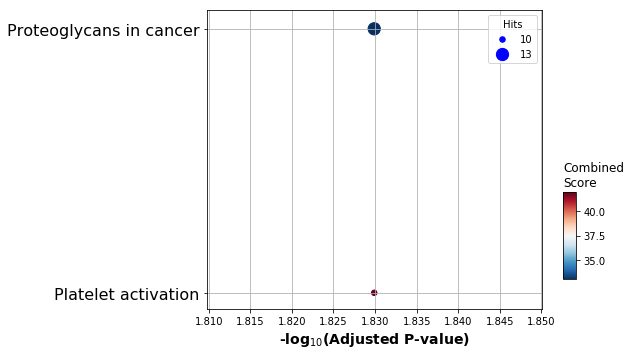

In [216]:
gp.plot.dotplot(enr_genes_dn.res2d, top_term=20)

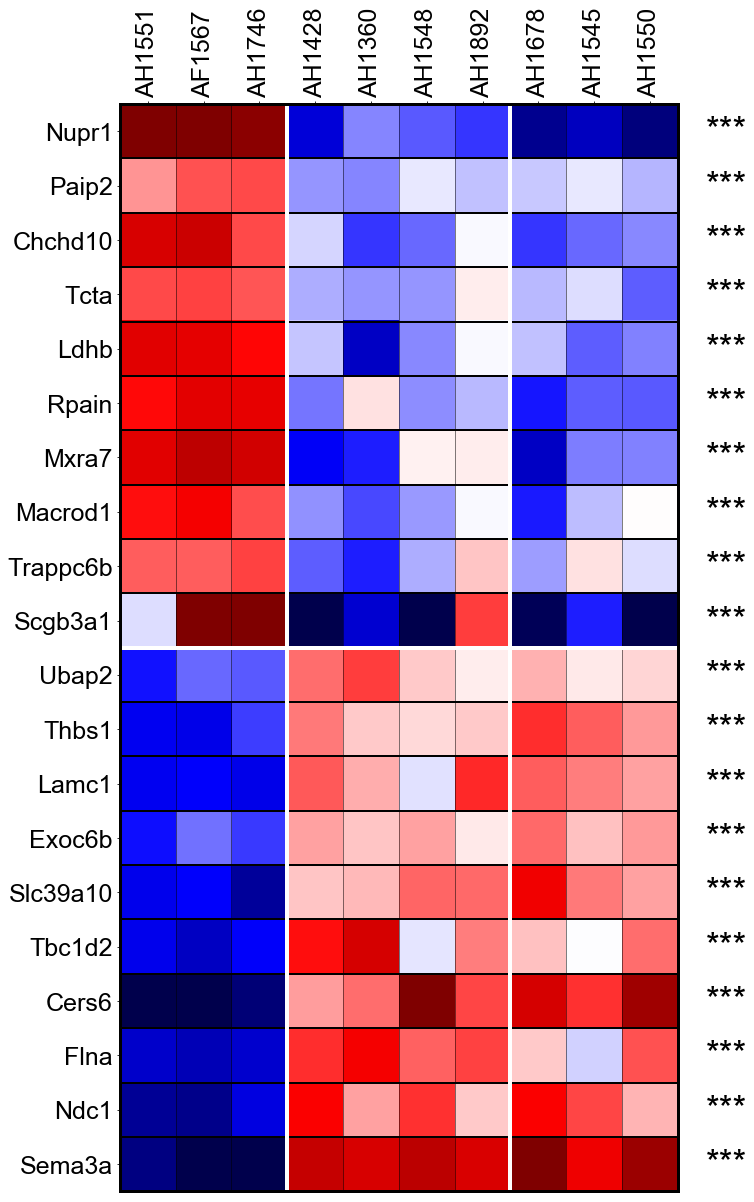

In [217]:
features = list(genes_up[0:10]) + list(genes_dn[0:10][::-1])
groups = c_sel
dat = cnts_DESeq2[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
padj = res['padj']
thr1 = 0.1
thr2 = 0.01
thr3 = 0.001
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

ax.axvline(2+0.5, linewidth = 4, color = 'w')
ax.axvline(6+0.5, linewidth = 4, color = 'w')
ax.axhline(9+0.5, linewidth = 4, color = 'w')

for i, f in enumerate(features):
    if f in padj.index:
        if padj[f] < thr3: ax.text(len(groups), i, '***', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr2: ax.text(len(groups), i, '**', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr1: ax.text(len(groups), i, '*', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')

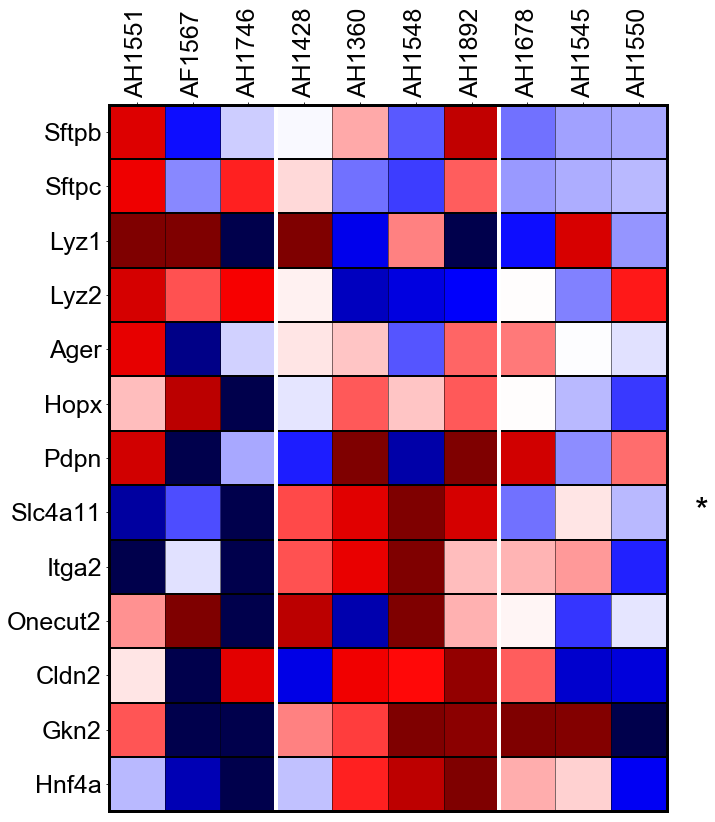

In [222]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Hopx','Pdpn','Slc4a11','Itga2','Onecut2','Cldn2','Gkn2','Hnf4a']
groups = c_sel
dat = cnts_DESeq2[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
padj = res['padj']
thr1 = 0.1
thr2 = 0.01
thr3 = 0.001
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

ax.axvline(2+0.5, linewidth = 4, color = 'w')
ax.axvline(6+0.5, linewidth = 4, color = 'w')

for i, f in enumerate(features):
    if f in padj.index:
        if padj[f] < thr3: ax.text(len(groups), i, '***', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr2: ax.text(len(groups), i, '**', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr1: ax.text(len(groups), i, '*', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')

## Correlation analysis

In [192]:
res_young = load_from_txt(path_output, exp_id, 'DESeq2_13772_I_young', 'DataFrame')
res_aged = load_from_txt(path_output, exp_id, 'DESeq2_13772_I_aged', 'DataFrame')

In [193]:
genes_young = res_young[(abs(res_young['log2FoldChange'])>0.1)&(res_young['padj']<0.1)]['padj'].sort_values().index
genes_aged = res_aged[(abs(res_aged['log2FoldChange'])>0.1)&(res_aged['padj']<0.1)]['padj'].sort_values().index

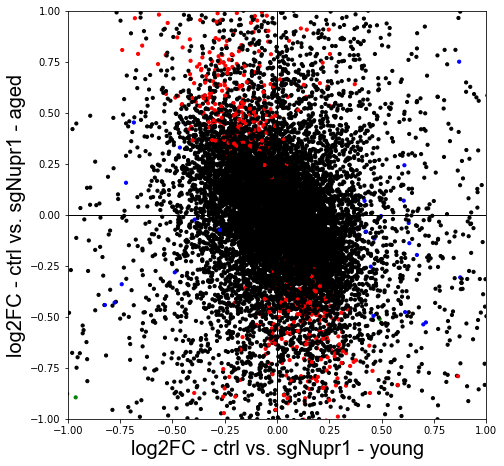

In [194]:
dat_x = res_young['log2FoldChange']
dat_y = res_aged['log2FoldChange']
genes_un_young = list(set(genes_young)-set(genes_aged))
genes_un_aged = list(set(genes_aged)-set(genes_young))
genes_shared = list(set(genes_young)&set(genes_aged))

#initialize figure

height = 7.5
width = 7.5

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)

#define x-axis

ax.set_xlabel('log2FC - ctrl vs. sgNupr1 - young', family='Arial', fontsize=20)
ax.set_xlim(-1,1)

#define y-axis

ax.set_ylabel('log2FC - ctrl vs. sgNupr1 - aged', family='Arial', fontsize=20)
ax.set_ylim(-1,1)


#draw center line

ax.axhline(0, color='k', lw=1)
ax.axvline(0, color='k', lw=1)

#define colorlist

clist=[]
for i in dat_x.index:
    if i in genes_un_young: clist.append('blue')
    elif i in genes_un_aged: clist.append('red')
    elif i in genes_shared: clist.append('green')
    else: clist.append('black')

#plot scatter

ax.scatter(dat_x, dat_y, s=10, color=clist)

# Expression of marker genes in aged and young

In [189]:
X = load_from_txt(path_output, exp_id, 'X_13772_I_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_13772_I', 'DataFrame')

## Filter unexpressed genes

In [190]:
X = filter_nonexpressed(X)

31017 genes in dataset
After removing non-expressed genes, 25111 genes remain


## Size factor normalisation in DESeq2

In [191]:
mat_to_DESEq2 = X
coldata_to_DESeq2 = M

In [192]:
%%R -i mat_to_DESEq2 -i coldata_to_DESeq2 -o cnts_DESeq2

dds <- DESeqDataSetFromMatrix(countData = mat_to_DESEq2, colData = coldata_to_DESeq2, design=~1)
dds <- estimateSizeFactors(dds) 
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [193]:
Xs = cnts_DESeq2

In [194]:
gr_order = [
    'AS1707', 'AS1712', 'AS1711', 'AU1855', 'AS1614', 'AS1710', 'AS1698',
    'AS1700', 'AS1609', 'AS1612', 'AS1709', 'AS1697', 'AS1611',
    'AT1426', 'AS1714', 'AT1428', 'AT1421', 'AT1420', 'AT1422', 'AT1429',
    'AH1551', 'AF1567', 'AH1746',
    'AH1428', 'AH1360', 'AH1548', 'AH1892',
    'AH1678', 'AH1545', 'AH1550'
]

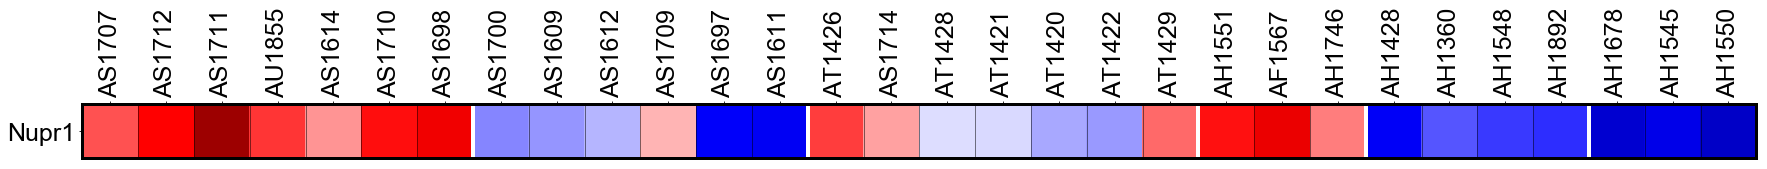

In [209]:
features = ['Nupr1']#,'Scgb1a1','Sftpb','Ager','Lyz2','Hopx','Pdpn','Itga2','Cldn4','Onecut2','Hmga2','Hnf4a','Gkn2']
groups = gr_order
dat = Xs[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -2, vmax = 2, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')
    
ax.axvline(6+0.5, linewidth = 4, color = 'w')
ax.axvline(12+0.5, linewidth = 4, color = 'w')
ax.axvline(19+0.5, linewidth = 4, color = 'w')
ax.axvline(22+0.5, linewidth = 4, color = 'w')
ax.axvline(26+0.5, linewidth = 4, color = 'w')

## Expression using group mean

In [196]:
groups = {'sgNT2_young':['AS1707', 'AS1712', 'AS1711', 'AU1855', 'AS1614', 'AS1710', 'AS1698',],
          'sg31_young':['AS1700', 'AS1609', 'AS1612', 'AS1709', 'AS1697', 'AS1611',],
          'sg32_young':['AT1426', 'AS1714', 'AT1428', 'AT1421', 'AT1420', 'AT1422', 'AT1429',],
          'sgNT2_aged':['AH1551', 'AF1567', 'AH1746',],
          'sg31_aged':['AH1428', 'AH1360', 'AH1548', 'AH1892',],
          'sg32_aged':['AH1678', 'AH1545', 'AH1550']}

In [197]:
Xs_mean = pd.DataFrame(columns = groups.keys(), index = Xs.index)
for gr in groups.keys():
    Xs_mean[gr] = cnts_DESeq2[groups[gr]].mean(axis=1)

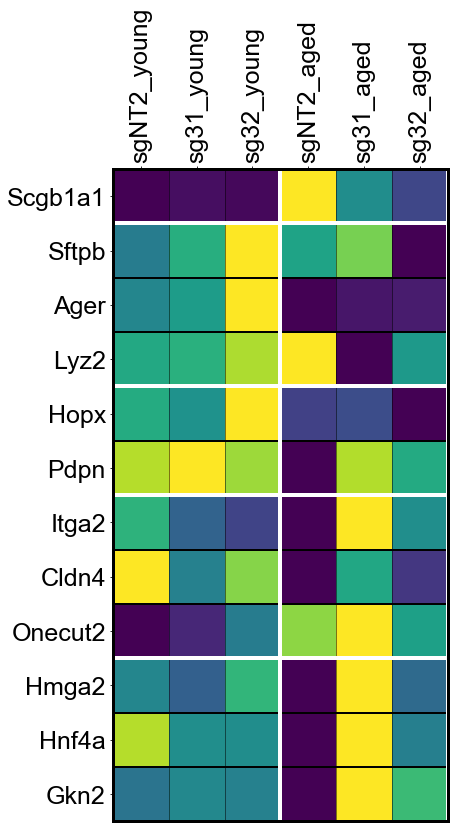

In [198]:
features = ['Scgb1a1','Sftpb','Ager','Lyz2','Hopx','Pdpn','Itga2','Cldn4','Onecut2','Hmga2','Hnf4a','Gkn2']
groups = ['sgNT2_young','sg31_young','sg32_young','sgNT2_aged','sg31_aged','sg32_aged']
dat = Xs_mean[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: (x-x.min()) / (x.max()-x.min()), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = 0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

ax.axvline(2+0.5, linewidth = 4, color = 'w')    
ax.axvline(5+0.5, linewidth = 4, color = 'w')
ax.axhline(0+0.5, linewidth = 4, color = 'w')
ax.axhline(3+0.5, linewidth = 4, color = 'w')
ax.axhline(5+0.5, linewidth = 4, color = 'w')
ax.axhline(8+0.5, linewidth = 4, color = 'w')

## Expression in aged using fold change

In [199]:
res = load_from_txt(path_output, exp_id, 'DESeq2_13772_I_aged', 'DataFrame')

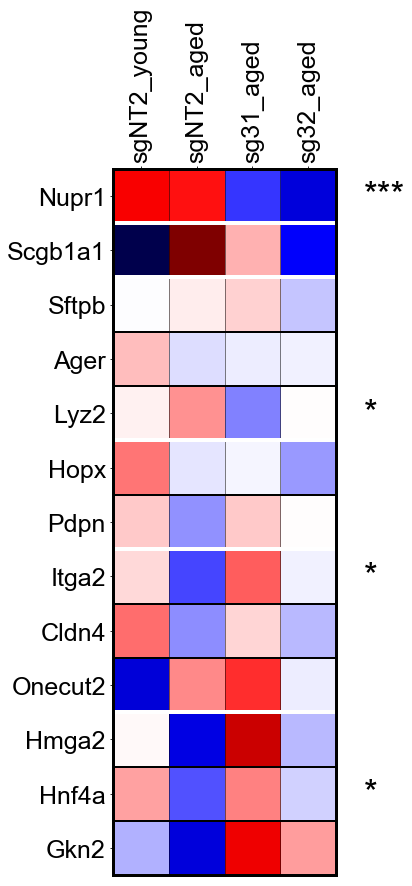

In [200]:
features = ['Nupr1','Scgb1a1','Sftpb','Ager','Lyz2','Hopx','Pdpn','Itga2','Cldn4','Onecut2','Hmga2','Hnf4a','Gkn2']
groups = ['sgNT2_young','sgNT2_aged','sg31_aged','sg32_aged']
dat = Xs_mean[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
padj = res['pvalue']
thr1 = 0.1
thr2 = 0.01
thr3 = 0.001
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -2, vmax = 2, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')
    
ax.axhline(0+0.5, linewidth = 4, color = 'w')
ax.axhline(1+0.5, linewidth = 4, color = 'w')
ax.axhline(4+0.5, linewidth = 4, color = 'w')
ax.axhline(6+0.5, linewidth = 4, color = 'w')
ax.axhline(9+0.5, linewidth = 4, color = 'w')

for i, f in enumerate(features):
    if f in padj.index:
        if padj[f] < thr3: ax.text(len(groups), i, '***', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr2: ax.text(len(groups), i, '**', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr1: ax.text(len(groups), i, '*', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
            

figname = 'invivo_Nupr1_heatmap_markers.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [ ]:
features = ['Nupr1','Scgb1a1','Lyz2','Itga2','Hnf4a']
groups = ['sgNT2_young','sgNT2_aged','sg31_aged','sg32_aged']
dat = Xs_mean[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: (x-x.min()) / (x.max()-x.min()), axis=1)
padj = res['pvalue']
thr1 = 0.1
thr2 = 0.01
thr3 = 0.001
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = 0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')
    
#ax.axhline(0+0.5, linewidth = 4, color = 'w')
ax.axhline(1+0.5, linewidth = 4, color = 'w')

for i, f in enumerate(features):
    if f in padj.index:
        if padj[f] < thr3: ax.text(len(groups), i, '***', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr2: ax.text(len(groups), i, '**', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr1: ax.text(len(groups), i, '*', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
            

figname = 'invivo_Nupr1_heatmap_markers_viridis.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

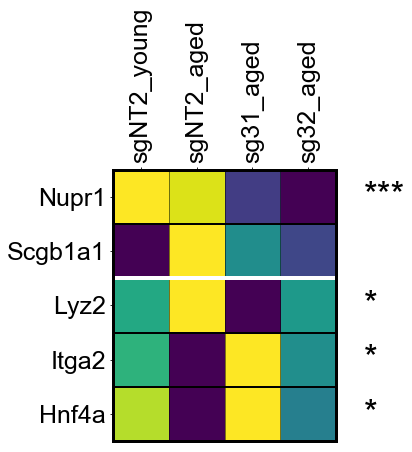

In [204]:
features = ['Nupr1','Scgb1a1','Lyz2','Itga2','Hnf4a']
groups = ['sgNT2_young','sgNT2_aged','sg31_aged','sg32_aged']
dat = Xs_mean[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: (x-x.min()) / (x.max()-x.min()), axis=1)
padj = res['pvalue']
thr1 = 0.1
thr2 = 0.01
thr3 = 0.001
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = 0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')
    
#ax.axhline(0+0.5, linewidth = 4, color = 'w')
ax.axhline(1+0.5, linewidth = 4, color = 'w')

for i, f in enumerate(features):
    if f in padj.index:
        if padj[f] < thr3: ax.text(len(groups), i, '***', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr2: ax.text(len(groups), i, '**', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
        elif padj[f] < thr1: ax.text(len(groups), i, '*', family = 'Arial', fontsize = 35, va = 'center', ha = 'left')
            

figname = 'invivo_Nupr1_heatmap_markers_viridis.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Expression of signatures

In [13]:
def sc2pd(scdata, layer, sparse=True):

    if sparse:
    
        if layer=='X':
            return pd.DataFrame(scdata.X.T.todense(),
                                index = scdata.var_names,
                                columns = scdata.obs_names)
        else:
            return pd.DataFrame(scdata.layers[layer].T.todense(),
                                index = scdata.var_names,
                                columns = scdata.obs_names)

    else:
    
        if layer=='X':
            return pd.DataFrame(scdata.X.T,
                                index = scdata.var_names,
                                columns = scdata.obs_names)
        else:
            return pd.DataFrame(scdata.layers[layer].T,
                                index = scdata.var_names,
                                columns = scdata.obs_names)

In [14]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

In [15]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % ('/Users/simjoo/Projects/10X_aging/data_output/v3/', '202111251525'))

In [16]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % ('/Users/simjoo/Projects/10X_aging/data_output/v3/', '202111251525'))

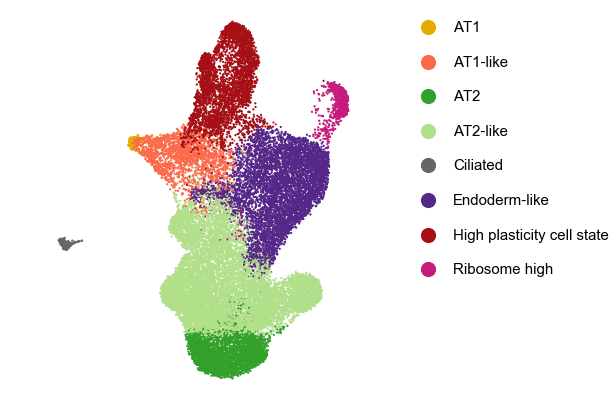

In [17]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['cl_epithelial_tumor_pca'],
                    cmap_epithelial_tumor,
                    s=5, show_axes=False)

In [18]:
pdX_mwu = sc2pd(Xs, 'norm_log2')

In [23]:
MWU_av_tumor_leiden = mwu_vs_average(pdX_mwu, Xs.obs['cl_epithelial_tumor_pca'], pdX_mwu.index, dview)

/Users/simjoo/Projects/aging_bulk_RNAseq/scripts/TenX_aging_mann_whitney_u_v1_0.py:82: RuntimeWarning: divide by zero encountered in log10
  output = -np.log10(output.astype(float))


In [24]:
#MWU_gr_tumor_leiden = mwu_vs_groups(pdX_mwu, Xs.obs['cl_epithelial_tumor_pca'], pdX_mwu.index, dview)

In [25]:
degs_gr = {}

for gr in MWU_av_tumor_leiden.columns:
    degs_gr[gr] = list(MWU_av_tumor_leiden[gr][MWU_av_tumor_leiden[gr]>10].index)
    print(gr, len(degs_gr[gr]))

AT2 1003
AT2-like 864
AT1 347
High plasticity cell state 741
Endoderm-like 875
Ciliated 320
Ribosome high 148
AT1-like 329


In [33]:
for i in degs_gr['Ribosome high']: print(i)

Dcpp1
Scgb3a2
Dlk1
Apoa1
Gkn2
Ly6d
Pf4
Apoe
Gzme
Acta2
Psca
S100a6
Trf
Mt1
Cdkn1c
Gstm1
Dmkn
Mt2
Rbp1
Apoc1
A2ml1
Crip1
S100a14
Calml4
Ckb
Ghrl
Id3
Fabp5
Basp1
Pclaf
Krt18
Ly6k
Rbp4
Tmem213
Id1
Tmsb10
Cdk1
Cdkn2a
Csrp2
Birc5
Fmo1
Gsto1
Gm10076
Fxyd2
Krt8
Pglyrp1
Rps3a3
S100a10
Cfi
Gpx2
Tspan1
2200002D01Rik
Sdcbp2
Mdk
Id2
Gsta3
Mif
Gsta4
Rps3a1
S100a16
Rps13-ps1
Afp
Cmbl
Bok
1110038B12Rik
Tubb5
Ckmt1
Fbp2
Tpi1
Rps15a-ps8
Mgst1
Rpl35
Cks2
Cela1
Bcl2a1b
Rpl12
Gapdh
Rps4l
S100a11
Pla2g1b
Ctsh
Cks1b
Hhex
Cbr3
Pkm
Myl12b
Arg2
Pgk1
Akr1b8
Pkib
Serpinb6a
Crip2
Cotl1
Cltrn
Tmem54
Eno1
Esd
Ppp1r14b
Myl12a
Adssl1
Gm8730
Ddc
Ifitm2
Smbd1
Hsbp1l1
Tpmt
Elf5
Ccdc88b
Akr1c13
Ddah2
Anxa3
Gstm5
Tst
Cstb
Sh3bgrl3
Bmyc
S100a1
Rpl15
Rps6
Selenoh
Eif2s2
Cdk4
Ftl1
1810058I24Rik
Pgam1
Mettl9
Fam162a
Dynlt1f
Rps10
Rps2
Tpt1-ps3
Rpl36al
Rpl32
Gpx4
Cbr1
Nhp2
Aldoa
S100a13
Msrb1
H2afz
Hspe1
Dctpp1
Rida
Nme1
Ranbp1
Dstn
Ptgr1
Mrpl32


In [39]:
X = load_from_txt(path_output, exp_id, 'X_13772_I_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_13772_I', 'DataFrame')

In [40]:
from sklearn.preprocessing import MaxAbsScaler

## Filter unexpressed genes

In [41]:
X = filter_nonexpressed(X)

31017 genes in dataset
After removing non-expressed genes, 25111 genes remain


## Size factor normalisation in DESeq2

In [42]:
mat_to_DESEq2 = X
classes_to_DESeq2 = M

In [43]:
%%R -i mat_to_DESEq2 -i classes_to_DESeq2 -o cnts_DESeq2

dds <- DESeqDataSetFromMatrix(countData = mat_to_DESEq2, colData = classes_to_DESeq2, design=~1)
dds <- estimateSizeFactors(dds) 
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [44]:
#Xs = np.log2(cnts_DESeq2+1)
Xs = cnts_DESeq2

## Get scores

In [45]:
X_maxabs = pd.DataFrame(MaxAbsScaler().fit_transform(Xs.T).T, index = Xs.index, columns=Xs.columns)

In [46]:
X_pop = pd.DataFrame(index = degs_gr.keys(), columns = X_maxabs.columns)

for i in degs_gr.keys():
    g_sel = [i for i in degs_gr[i] if i in X_maxabs.index]
    X_pop.loc[i] = X_maxabs.loc[g_sel].sum()

In [47]:
gr_order = [
    'AS1707', 'AS1712', 'AS1711', 'AU1855', 'AS1614', 'AS1710', 'AS1698',
    'AS1700', 'AS1609', 'AS1612', 'AS1709', 'AS1697', 'AS1611',
    'AT1426', 'AS1714', 'AT1428', 'AT1421', 'AT1420', 'AT1422', 'AT1429',
    'AH1551', 'AF1567', 'AH1746',
    'AH1428', 'AH1360', 'AH1548', 'AH1892',
    'AH1678', 'AH1545', 'AH1550'
]

In [48]:
X_pop

,AT1426,AH1428,AS1707,AS1714,AT1428,AS1712,AH1678,AH1545,AS1711,AH1551,...,AT1422,AF1567,AH1746,AS1612,AT1429,AS1709,AS1697,AH1892,AS1611,AS1698
AT2,855.999,863.695,864.52,862.218,862.43,864.585,864.821,868.034,842.587,862.533,...,860.449,879.978,877.304,859.455,848.043,843.027,861.186,847.354,869.907,854.132
AT2-like,726.101,739.445,738.652,721.147,721.593,733.628,743.285,745.074,719.068,735.402,...,726.745,737.748,751.527,728.367,714.204,708.098,731.95,719.463,740.831,721.232
AT1,311.171,309.056,312.627,320.856,310.733,312.661,307.678,310.52,317.256,306.209,...,312.006,310.135,303.127,313.482,317.66,313.523,309.395,311.64,313.918,306.682
High plasticity cell state,635.577,629.171,616.594,625.948,618.638,628.1,625.494,635.99,650.55,620.018,...,624.983,627.658,598.887,610.714,647.348,641.85,619.595,634.608,629.089,619.538
Endoderm-like,727.461,714.774,697.61,730.124,709.509,708.878,720.366,731.024,723.432,719.669,...,709.855,715.868,702.81,695.171,726.999,718.218,712.883,733.733,723.167,711.562
Ciliated,271.791,262.606,258.548,270.316,263.692,261.737,264.623,265.345,266.613,264.428,...,263.942,305.363,261.527,258.318,264.632,269.925,261.642,262.475,264.196,262.132
Ribosome high,127.755,119.295,115.077,124.865,124.051,118.809,119.355,122.386,121.656,124.366,...,121.467,118.334,116.252,114.433,124.792,126.512,121.65,125.59,120.393,122.905
AT1-like,289.818,288.441,292.18,300.688,287.342,292.713,288.632,291.218,296.262,284.976,...,290.007,286.507,282.572,293.383,298.061,291.319,289.195,292.179,291.848,286.778


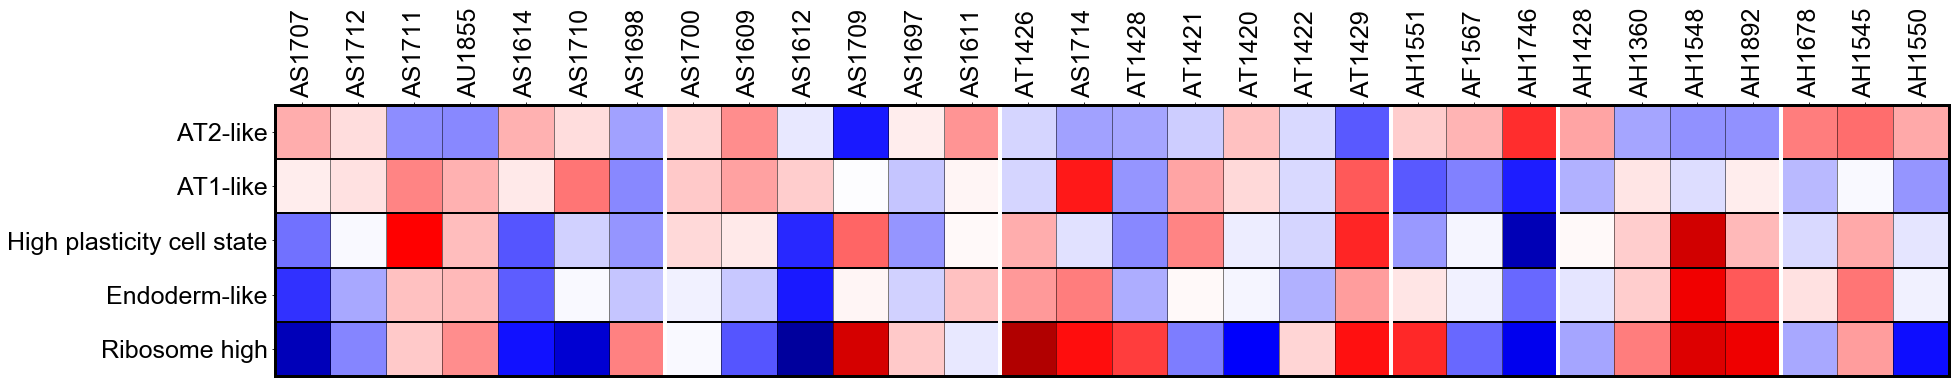

In [49]:
features = ['AT2-like','AT1-like','High plasticity cell state','Endoderm-like','Ribosome high']
groups = gr_order
dat = X_pop[groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -0.1, vmax = 0.1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')
    
ax.axvline(6+0.5, linewidth = 4, color = 'w')
ax.axvline(12+0.5, linewidth = 4, color = 'w')
ax.axvline(19+0.5, linewidth = 4, color = 'w')
ax.axvline(22+0.5, linewidth = 4, color = 'w')
ax.axvline(26+0.5, linewidth = 4, color = 'w')

In [60]:
groups = {'sgNT2_young':['AS1707', 'AS1712', 'AS1711', 'AU1855', 'AS1614', 'AS1710', 'AS1698',],
          'sg31_young':['AS1700', 'AS1609', 'AS1612', 'AS1709', 'AS1697', 'AS1611',],
          'sg32_young':['AT1426', 'AS1714', 'AT1428', 'AT1421', 'AT1420', 'AT1422', 'AT1429',],
          'sgNT2_aged':['AH1551', 'AF1567', 'AH1746',],
          'sg31_aged':['AH1428', 'AH1360', 'AH1548', 'AH1892',],
          'sg32_aged':['AH1678', 'AH1545', 'AH1550']}

In [51]:
X_pop_mean = pd.DataFrame(columns = groups.keys(), index = X_pop.index)
for gr in groups.keys():
    X_pop_mean[gr] = X_pop[groups[gr]].mean(axis=1)

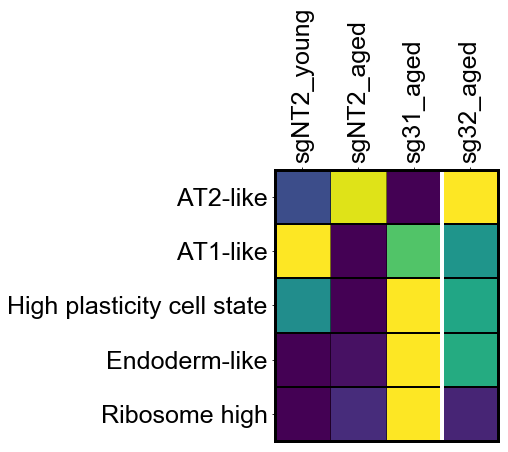

In [75]:
features = ['AT2-like','AT1-like','High plasticity cell state','Endoderm-like','Ribosome high']
groups = ['sgNT2_young','sgNT2_aged','sg31_aged','sg32_aged']
dat = X_pop_mean[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: (x-x.min()) / (x.max()-x.min()), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = 0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

ax.axvline(2+0.5, linewidth = 4, color = 'w')

figname = 'invivo_Nupr1_heatmap_signatures.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [61]:
groups = {'sgNT2_young':['AS1707', 'AS1712', 'AS1711', 'AU1855', 'AS1614', 'AS1710', 'AS1698',],
          'sg31_young':['AS1700', 'AS1609', 'AS1612', 'AS1709', 'AS1697', 'AS1611',],
          'sg32_young':['AT1426', 'AS1714', 'AT1428', 'AT1421', 'AT1420', 'AT1422', 'AT1429',],
          'sgNT2_aged':['AH1551', 'AF1567', 'AH1746',],
          'sg31_aged':['AH1428', 'AH1360', 'AH1548', 'AH1892',],
          'sg32_aged':['AH1678', 'AH1545', 'AH1550']}

In [68]:
pval_sgNupr1 = pd.Series(index = X_pop.index)

for i in X_pop.index:
    pval_sgNupr1[i] = scipy.stats.mannwhitneyu(X_pop.loc[i][groups['sgNT2_aged']].values,
                                               X_pop.loc[i][groups['sg31_aged']+groups['sg32_aged']].values)[1]

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [70]:
pval_sgNupr1

AT2                           0.085730
AT2-like                      0.324252
AT1                           0.085730
High plasticity cell state    0.034124
Endoderm-like                 0.085730
Ciliated                      0.500000
Ribosome high                 0.180967
AT1-like                      0.011327
dtype: float64

In [71]:
pval_sg31 = pd.Series(index = X_pop.index)

for i in X_pop.index:
    pval_sg31[i] = scipy.stats.mannwhitneyu(X_pop.loc[i][groups['sgNT2_aged']].values,
                                               X_pop.loc[i][groups['sg31_aged']].values)[1]

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [72]:
pval_sg31

AT2                           0.055806
AT2-like                      0.107962
AT1                           0.107962
High plasticity cell state    0.025915
Endoderm-like                 0.107962
Ciliated                      0.429842
Ribosome high                 0.107962
AT1-like                      0.025915
dtype: float64

In [73]:
pval_sg32 = pd.Series(index = X_pop.index)

for i in X_pop.index:
    pval_sg32[i] = scipy.stats.mannwhitneyu(X_pop.loc[i][groups['sgNT2_aged']].values,
                                               X_pop.loc[i][groups['sg32_aged']].values)[1]

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [74]:
pval_sg32

AT2                           0.331260
AT2-like                      0.331260
AT1                           0.191367
High plasticity cell state    0.191367
Endoderm-like                 0.191367
Ciliated                      0.500000
Ribosome high                 0.500000
AT1-like                      0.040428
dtype: float64

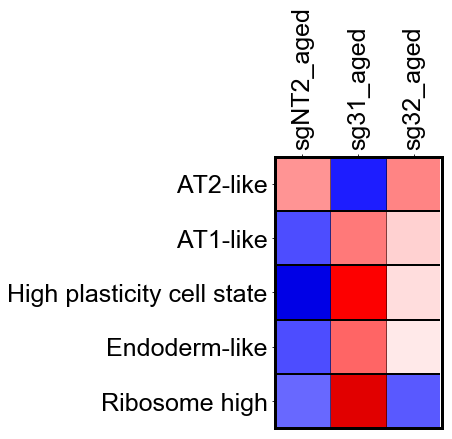

In [53]:
features = ['AT2-like','AT1-like','High plasticity cell state','Endoderm-like','Ribosome high']
groups = ['sgNT2_aged','sg31_aged','sg32_aged']
dat = X_pop_mean[groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -0.05, vmax = 0.05, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

ax.axvline(2+0.5, linewidth = 4, color = 'w')

# Diffusion map modeling

In [152]:
X = load_from_txt(path_output, exp_id, 'X_13772_I_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_13772_I', 'DataFrame')

## Select young control and all aged

In [153]:
c_sel1 = M[(M['Age']=='Y')&(M['Treatment']=='sgNT2')].index

In [154]:
len(c_sel1)

7

In [155]:
c_sel2 = M[(M['Age']=='A')].index

In [156]:
len(c_sel2)

10

In [157]:
c_sel = list(c_sel1) + list (c_sel2)

In [158]:
X = X[c_sel]
M = M.loc[c_sel]

## Filter unexpressed genes

In [159]:
X = filter_nonexpressed(X)

31017 genes in dataset
After removing non-expressed genes, 23607 genes remain


## Size factor normalisation in DESeq2

In [160]:
mat_to_DESEq2 = X
coldata_to_DESeq2 = M

In [161]:
%%R -i mat_to_DESEq2 -i coldata_to_DESeq2 -o cnts_DESeq2

dds <- DESeqDataSetFromMatrix(countData = mat_to_DESEq2, colData = coldata_to_DESeq2, design=~1)
dds <- estimateSizeFactors(dds) 
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [162]:
Xs = cnts_DESeq2

## Only consider genes which were DE in tumor cell states

In [163]:
list_degs = []

for k in degs_gr.keys():
    list_degs += degs_gr[k]

In [164]:
list_degs = [i for i in list(set(list_degs)) if i in Xs.index]

In [165]:
len(list_degs)

2254

In [166]:
Xs = Xs.loc[list_degs]

## Feature selection

In [89]:
#feat = filter_genes(Xs, min_mean=50).index

23607 genes in dataset
After removing genes with mean expression of less than 50 reads, 11683 genes remain


In [90]:
#feat = select_features_vst(Xs.loc[feat], n_features = 5000)

In [91]:
#Xs = Xs.loc[feat]

## log2 transformation

In [167]:
Xs = np.log2(Xs+1)

## PCA

In [168]:
from sklearn.decomposition import PCA

In [169]:
pca = PCA(n_components=5)
pcs = pd.DataFrame(pca.fit_transform(Xs.T), index = Xs.columns, columns = range(5))

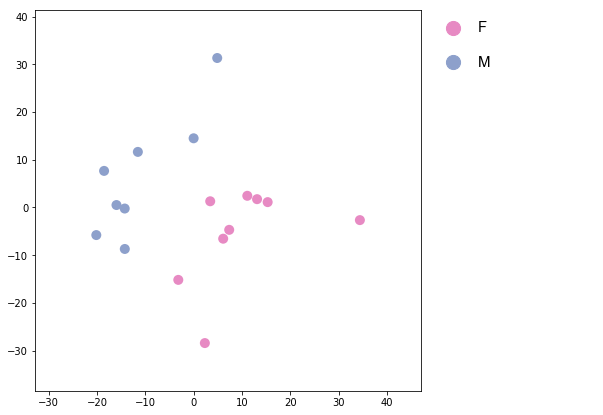

In [170]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M['Sex'][pcs.index],
                    cmap = cmap_sex,
                    s = 100,
                    pad = 10e0)

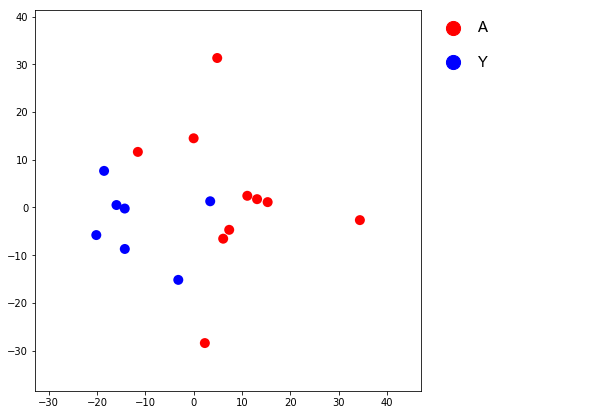

In [171]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M['Age'][pcs.index],
                    cmap = cmap_age,
                    s = 100,
                    pad = 10e0)

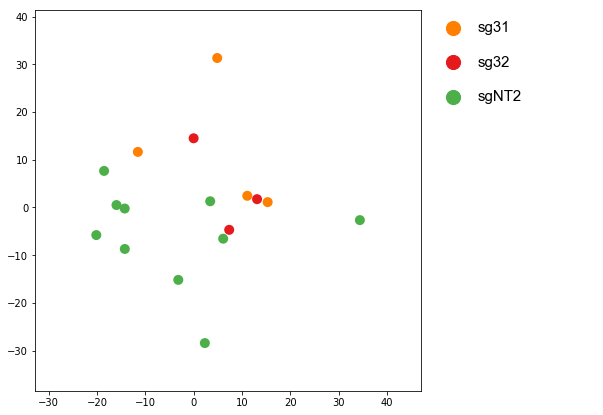

In [172]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M['Treatment'][pcs.index],
                    cmap = cmap_treatment,
                    s = 100,
                    pad = 10e0)

Text(0.5, 0, 'PC3')

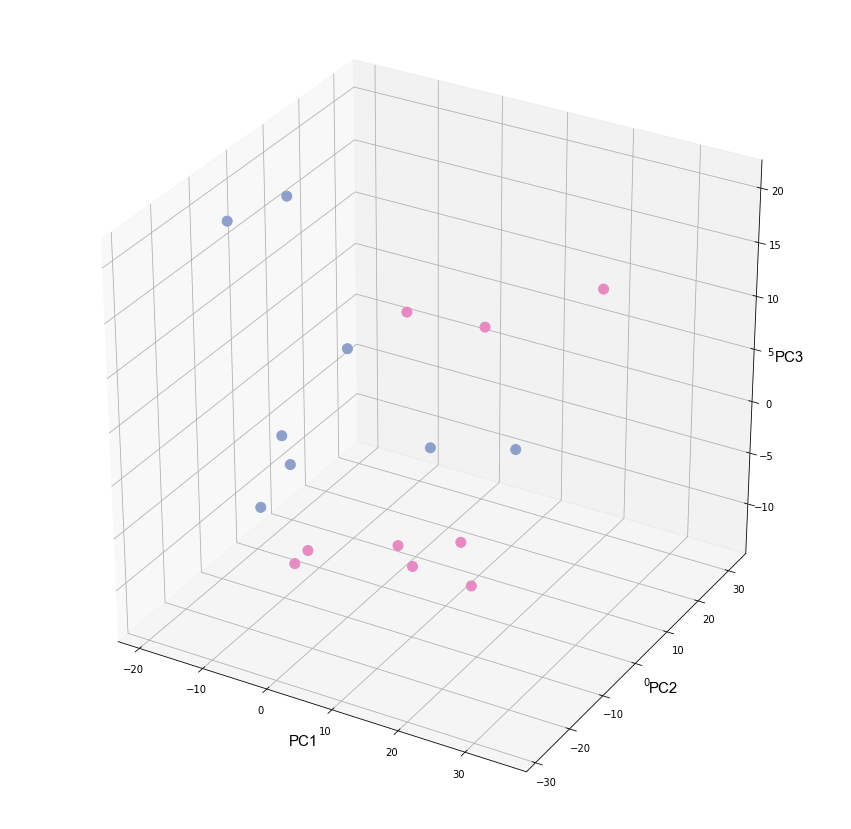

In [173]:
coords = np.array(pcs)[:,0:3]
groups = M['Sex'][pcs.index]
cmap = cmap_sex


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

Text(0.5, 0, 'PC3')

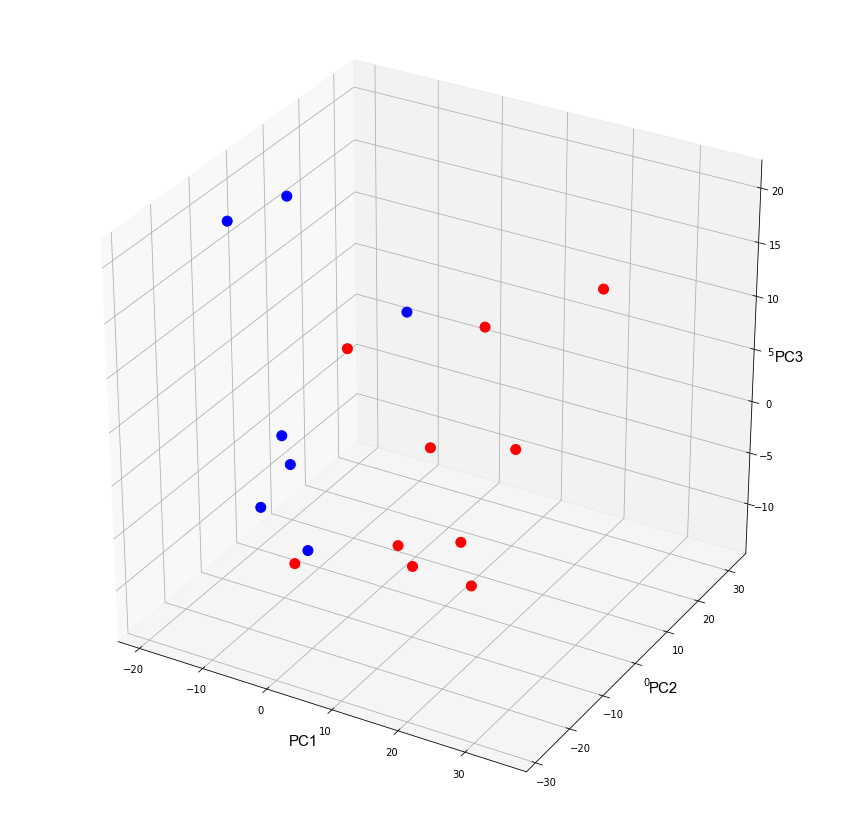

In [174]:
coords = np.array(pcs)[:,0:3]
groups = M['Age'][pcs.index]
cmap = cmap_age


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

Text(0.5, 0, 'PC3')

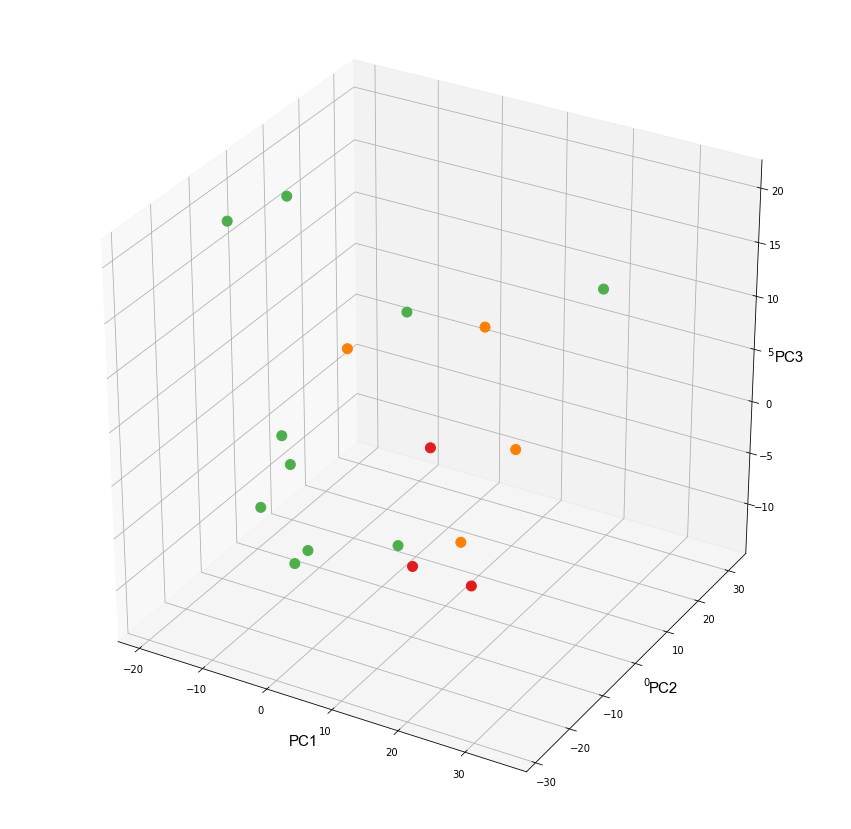

In [175]:
coords = np.array(pcs)[:,0:3]
groups = M['Treatment'][pcs.index]
cmap = cmap_treatment


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

## Diffusion map

In [176]:
def pd2sc(df):
    
    X = df
    
    obs = pd.DataFrame(index = X.columns)
    
    var = pd.DataFrame(index = X.index)
    
    scdata = sc.AnnData(np.array(X.T), obs = obs, var = var)
    scdata.var_names_make_unique()
    scdata.obs_names_make_unique()

    return scdata

In [177]:
scX = pd2sc(Xs)
scX.obs = M

In [184]:
sc.tl.pca(scX, n_comps=10)

In [185]:
sc.pp.neighbors(scX, n_neighbors=10, n_pcs=50, method='gauss', use_rep='X_pca')

In [186]:
sc.tl.diffmap(scX, n_comps=3)

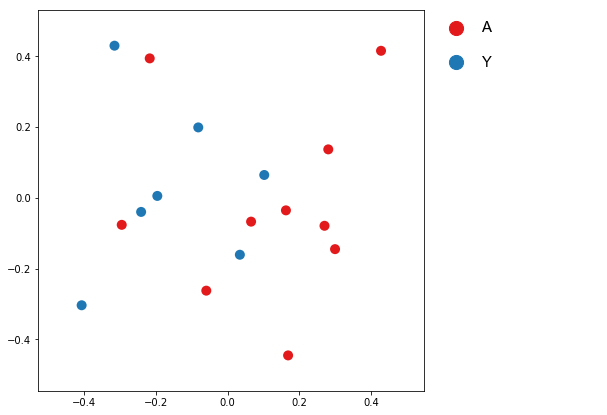

In [187]:
draw_scatter_groups(scX.obsm['X_diffmap'][:,(1,2)], 
                    M['Age'][scX.obs_names],
                    cmap = {'Y':'#1f78b4','A':'#e31a1c'},
                    s = 100,
                    pad = 0.1)

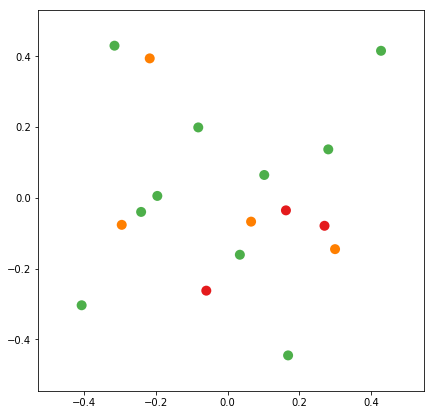

In [188]:
draw_scatter_groups(scX.obsm['X_diffmap'][:,(1,2)], 
                    M['Treatment'][scX.obs_names],
                    cmap = cmap_treatment,
                    s = 100,
                    pad = 0.1, show_legend=False)